<a href="https://colab.research.google.com/github/rpasquini/urban-econometrics/blob/master/CIA_y_Matching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [165]:
import pandas as pd
import statsmodels.api as sm  
from scipy import stats  
import numpy as np
from sklearn.neighbors import KNeighborsRegressor

In [166]:
df=pd.read_csv('https://raw.githubusercontent.com/rpasquini/econometrics_and_causality/master/happiness_on_tap_extract.csv')

In [167]:
df['dsexojefe']=np.where(df['sexojefe']==1,1,0)

Extracto de datos de:

[Devoto, F., Duflo, E., Dupas, P., Parienté, W., & Pons, V. (2012). Happiness on tap: piped water adoption in urban Morocco. American Economic Journal: Economic Policy, 4(4), 68-99.](https://web.stanford.edu/~pdupas/MoroccoWaterConnections.pdf)

Las variables fueron modificadas para el proposito de este ejercicio.

Descripción de variables

motivacion: Dummy = 1 si el hogar recibió motivación para conexión \
conectado: Dummy = 1 si el hogar se conectó a la red de agua \
sexojefe:  1 Masculino, 2 Femenino \
edadjefe: Edad Jefe de Hogar \
jefesabeleer: Dummy=1 Jefe sabe leer \
jefesabeescribir: Dummy=1 Jefe sabe escribir \
pdiasfueaescuela: Porcentaje dias hijos fueron a la escuela.

In [168]:
df=df.dropna()

Diferencia entre conectados y no conectados sugiere 

In [169]:
df.loc[df.conectado==1].pdiasfueaescuela.mean()-df.loc[df.conectado==0].pdiasfueaescuela.mean()

-3.523604421369349

Antes de continuar verificamos si hay diferencias en las caracteristicas observables


In [170]:
for variable in ['sexojefe','edadjefe','jefesabeleer','jefesabeescribir','pdiasfueaescuela']:
  var_tratados=df[variable].loc[(df.conectado==1) ]
  var_control=df[variable].loc[(df.conectado==0) ]
  print(variable)
  print('dif: ',var_tratados.mean()-var_control.mean())
  resultadottest=stats.ttest_ind(var_tratados, var_control, equal_var=True)
  print('statistic', resultadottest.statistic, 'pvalue', resultadottest.pvalue)


sexojefe
dif:  -0.014426908974972008
statistic -0.3985894717651943 pvalue 0.6904657650625463
edadjefe
dif:  -0.7358919177427055
statistic -0.6786088936491492 pvalue 0.4978839468444204
jefesabeleer
dif:  -0.06260959668420218
statistic -1.2386725523291628 pvalue 0.21638902860325182
jefesabeescribir
dif:  -0.05519687549816665
statistic -1.0737778188107645 pvalue 0.28374413297112716
pdiasfueaescuela
dif:  -3.523604421369349
statistic -1.224783170253449 pvalue 0.22157203698942263


# Recuperando el ATT usando la CIA.
A los fines de un primer ejemplo, vamos a suponer que es suficiente con el control por el sexo del jefe de hogar para eliminar el posible sesgo de selección. 
El estimador que propone la teoría es:

$$ATT=E[Y_{1i}∣T_{i}=1]-E[Y_{0i}∣T_{i}=1]=\sum_x\delta_xP(X_i=x|T_i=1)$$

In [171]:
# Diferencia para jefes hombres
dif_hombres=df.loc[(df.conectado==1)& (df.sexojefe==1)].pdiasfueaescuela.mean() \
-df.loc[(df.conectado==0)&(df.sexojefe==1)].pdiasfueaescuela.mean()
print('dif_hombres ',dif_hombres)
# Diferencia para jefes mujeres

dif_mujeres=df.loc[(df.conectado==1)& (df.sexojefe==2)].pdiasfueaescuela.mean() \
-df.loc[(df.conectado==0)&(df.sexojefe==2)].pdiasfueaescuela.mean()
print('dif_mujeres ',dif_mujeres)


dif_hombres  -3.090223847986074
dif_mujeres  -6.808688535087732


In [172]:
total_hombres=df.loc[(df.sexojefe==1) ].shape[0]
total_mujeres= df.loc[(df.sexojefe==2)].shape[0]
print('total hombres  ', total_hombres, ', total mujeres ', total_mujeres)


total_hombres_tratados=df.loc[(df.sexojefe==1) & (df.conectado==1)].shape[0]
total_mujeres_tratadas= df.loc[(df.sexojefe==2) & (df.conectado==1)].shape[0]
print('total hombres tratados ', total_hombres_tratados, ', total mujeres tratadas ', total_mujeres_tratadas)



total hombres   280 , total mujeres  37
total hombres tratados  146 , total mujeres tratadas  18


In [173]:
# ATT
(dif_hombres*total_hombres_tratados+dif_mujeres*total_mujeres_tratadas)/(146+18)

-3.4983480209606466

In [174]:
# ATE
(dif_hombres*total_hombres+dif_mujeres*total_mujeres)/(280+37)


-3.5242402310231764

In [175]:
df.pdiasfueaescuela.mean()

59.80171416088331

# Algoritmo de Matching

Para el ATT, la idea es asignarle a cada tratado una pareja en el control, basandome en todas las caracteristicas observables.
Vamos a usar una función de la libreria sklearn, que busca a partir de un conjunto de caracteristicas, la observación más similar, y devuelve el resultado de esa observación.
El metodo de Kneighbors se utiliza para hacer predicciones en general y esta es una adaptacion a nuestro caso de interes.


In [176]:
# Llamemos X a la lista de variables que vamos a considerar para el matching
X=['dsexojefe', 'edadjefe', 'jefesabeleer', 'jefesabeescribir']


In [177]:
# Separo las observaciones de conectados y no conectados
conectados = df.loc[(df.conectado==1)]
noconectados = df.loc[(df.conectado==0)]

# KNeighborsRegressor necesita que 'entrene' un modelo, que va a aprender a buscar el resultado de un 'no conectado' cuando le pida que 'prediga' uno.
# El 'entrenamiento' es equivalente al 'ajuste' de nuestro modelo de regresion.

modelo_no_conectados = KNeighborsRegressor(n_neighbors=1).fit(noconectados[X], noconectados.pdiasfueaescuela)

# le pido al modelo que obtenga la pareja de no conectado (predecir el no conectado correspondiente)

df_matcheado=conectados.assign(matchnoconectado=modelo_no_conectados.predict(conectados[X]))
df_matcheado

,random_id,motivacion,conectado,sexojefe,edadjefe,jefesabeleer,jefesabeescribir,pdiasfueaescuela,dsexojefe,matchnoconectado
1,3,1,1,1,45.0,0.0,0.0,57.142860,1,14.285715
3,7,1,1,1,54.0,1.0,1.0,85.714287,1,85.714287
7,11,0,1,1,52.0,1.0,1.0,71.428574,1,71.428574
13,21,1,1,1,51.0,1.0,1.0,71.428574,1,71.428574
18,26,1,1,1,45.0,1.0,1.0,57.142860,1,28.571430
...,...,...,...,...,...,...,...,...,...,...
766,1012,1,1,2,41.0,0.0,0.0,42.857143,0,71.428574
768,1014,0,1,1,36.0,1.0,1.0,14.285715,1,71.428574
772,1018,1,1,1,51.0,1.0,1.0,85.714287,1,71.428574
778,1025,0,1,1,39.0,0.0,0.0,14.285715,1,71.428574


In [178]:
np.mean(df_matcheado.pdiasfueaescuela-df_matcheado.matchnoconectado)

-5.313588926829269

# Propensity Score Matching 

Mostramos la idea del propensity score utilizando el mismo procedimiento que para el matching, pero en este caso vamos a matchear sobre la probabilidad

In [179]:
def logit(lista, data):
  """ 
  Funcion que realiza la regresion Logit
  La primera variable de la lista es la dependiente, el resto son las explicativas
  data es la base de datos
  """
  datos=data[lista]
  # el metodo dropna() me permite eliminar las filas que tienen algun valor missing
  datos=datos.dropna()
  Y=datos[lista[0]]
  X=datos[lista[1:]]
  X=sm.add_constant(X)
  modelo=sm.Logit(Y,X)
  modeloajustado=modelo.fit()
  print(modeloajustado.summary())
  return modeloajustado

In [180]:
modelo=logit(['conectado','dsexojefe', 'edadjefe', 'jefesabeleer', 'jefesabeescribir'], data=df)
df['probabilidades']=modelo.predict()

Optimization terminated successfully.
         Current function value: 0.687622
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:              conectado   No. Observations:                  317
Model:                          Logit   Df Residuals:                      312
Method:                           MLE   Df Model:                            4
Date:                Fri, 07 Aug 2020   Pseudo R-squ.:                0.007109
Time:                        00:38:24   Log-Likelihood:                -217.98
converged:                       True   LL-Null:                       -219.54
Covariance Type:            nonrobust   LLR p-value:                    0.5377
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.5142      0.678      0.758      0.448      -0.815       1.843
dsexojefe  

In [189]:
df.head()

,random_id,motivacion,conectado,sexojefe,edadjefe,jefesabeleer,jefesabeescribir,pdiasfueaescuela,dsexojefe,probabilidades
1,3,1,1,1,45.0,0.0,0.0,57.142860,1,0.605246
2,5,0,0,1,50.0,1.0,1.0,85.714287,1,0.493662
3,7,1,1,1,54.0,1.0,1.0,85.714287,1,0.484496
7,11,0,1,1,52.0,1.0,1.0,71.428574,1,0.489078
9,14,0,0,1,42.0,1.0,1.0,42.857143,1,0.511999


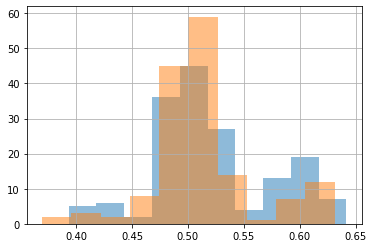

In [181]:
# Vemos que haya un soporte comun en las distribuciones
df.loc[df.conectado==1]['probabilidades'].hist( alpha=0.5)
df.loc[df.conectado==0]['probabilidades'].hist(alpha=0.5)

In [182]:
# KNeighborsRegressor para buscar parejas
# Separo las observaciones de conectados y no conectados
conectados = df.loc[(df.conectado==1)]
noconectados = df.loc[(df.conectado==0)]


modelo_no_conectados = KNeighborsRegressor(n_neighbors=1).fit(noconectados['probabilidades'].values.reshape(-1, 1), noconectados.pdiasfueaescuela)

# le pido al modelo que obtenga la pareja de no conectado (predecir el no conectado correspondiente)

df_matcheado=conectados.assign(matchnoconectado=modelo_no_conectados.predict(conectados['probabilidades'].values.reshape(-1, 1)))

df_matcheado

,random_id,motivacion,conectado,sexojefe,edadjefe,jefesabeleer,jefesabeescribir,pdiasfueaescuela,dsexojefe,probabilidades,matchnoconectado
1,3,1,1,1,45.0,0.0,0.0,57.142860,1,0.605246,14.285715
3,7,1,1,1,54.0,1.0,1.0,85.714287,1,0.484496,85.714287
7,11,0,1,1,52.0,1.0,1.0,71.428574,1,0.489078,85.714287
13,21,1,1,1,51.0,1.0,1.0,71.428574,1,0.491370,85.714287
18,26,1,1,1,45.0,1.0,1.0,57.142860,1,0.505124,42.857143
...,...,...,...,...,...,...,...,...,...,...,...
766,1012,1,1,2,41.0,0.0,0.0,42.857143,0,0.534512,42.857143
768,1014,0,1,1,36.0,1.0,1.0,14.285715,1,0.525734,71.428574
772,1018,1,1,1,51.0,1.0,1.0,85.714287,1,0.491370,85.714287
778,1025,0,1,1,39.0,0.0,0.0,14.285715,1,0.618313,71.428574


In [183]:
np.mean(df_matcheado.pdiasfueaescuela-df_matcheado.matchnoconectado)

-2.613240280487805

# Utilizando la libreria Causal Inference


In [184]:
!pip install causalinference

In [185]:
from causalinference import CausalModel

In [186]:
X=['dsexojefe', 'edadjefe', 'jefesabeleer', 'jefesabeescribir']

In [187]:
cm = CausalModel( Y=df["pdiasfueaescuela"].values,  D=df["conectado"].values,  X=df[X].values )

cm.est_via_matching(matches=1, bias_adj=True)

print(cm.estimates)
cm.reset()


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE     -0.709      3.913     -0.181      0.856     -8.378      6.959
           ATC      0.221      4.235      0.052      0.958     -8.080      8.522
           ATT     -1.577      4.224     -0.373      0.709     -9.856      6.701



/usr/local/lib/python3.6/dist-packages/causalinference/estimators/matching.py:100: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return np.linalg.lstsq(X, Y)[0][1:]  # don't need intercept coef


# Propensity Score using Causal Model

In [188]:
causal = CausalModel(
    Y=df["pdiasfueaescuela"].values, 
    D=df["conectado"].values, 
    X=df[X].values
)
causal.est_propensity_s()
print(causal.propensity)
causal.stratify_s()
print(causal.strata)



Estimated Parameters of Propensity Score

                    Coef.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
     Intercept      0.294      0.214      1.373      0.170     -0.126      0.714
            X2     -0.312      0.252     -1.238      0.216     -0.806      0.182


Stratification Summary

              Propensity Score         Sample Size     Ave. Propensity   Outcome
   Stratum      Min.      Max.  Controls   Treated  Controls   Treated  Raw-diff
--------------------------------------------------------------------------------
         1     0.496     0.573       153       164     0.515     0.520    -3.524

